In [1]:
from tensorflow.keras import models, layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# 데이터 불러오는 부분
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [3]:
# 스케일링 하는 부분 (이미지 원본으로 불러옴)
# resshape (imgaes, rows, columns, channels)
# 흑백은 채널1, 컬러는 3
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype(float) / 255
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype(float) / 255
y_train = to_categorical(y_train) # 넘파이배열을 원핫인코딩 : to_categorical
y_test = to_categorical(y_test)

In [4]:
model = models.Sequential()
# 이미지 1장이 들어오면 3x3 커널을 만드는데, 1장의 이미지를 32장(커널을 32개 두고서)으로 만들겠다
model.add(layers.Conv2D(32, kernel_size=(3,3), input_shape=(28,28,1), activation='relu'))
# 3x3 커널의 각 위치의 값이 weight 파라미터
# 커널별로 bias가 생성됨

# 왜 커널을 32개나 만들어서 32장을 뽑냐?
# 각각의 커널이 여러가지 특징을 다 잡아낼수 있도록 충분하게 만들어준것임

# 커널 1장당 64장을 쪼개개했는데, 이전에서 뽑은 32장이 와서 (32 x w) * (w x 64) + 64 
model.add(layers.Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
# 과적합(overfitting) 을 방지하는 드랍아웃
model.add(layers.Dropout(0.25))
# flatten층은 위에 몇차원이 들어오던간에 1차원으로 쫙 펴줌 (Dense 층으로 집어넣으려고)
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))
model.summary()


# 1. (1) * (3 x 3) * (32) + 32=> w = 288 / bias = 32 / total = 320 => 이미지크기 28* 28 => (28-2) * (28-2)
# 2. (32) *  (3 x 3)* (64) + 64 =>  w =18432 / bias = 32 / total = 18496 => 이미지크기 (28-2) * (28-2) => (28-4) * (28-4)
# 3. 이미지 크기 24 * 24였는데 (2,2) maxpooling 하면서 1/4토막 > 가로세로 절반됨
# 4. Flatten ==> 1차원으로 눌러서 12 * 12 크기의 64개 ==> 입력 9216
# 5. (9216) * (128) + 128 =>  w = 1179648 / bias = 128 / total = 1179776
# 6. (128) * (10) + 10 = w = 1280 / bias = 10 / total = 1290
# * Dropout 은 파라미터 영향, Shape 영향 x
# * MaxPooling은 추가적인 파라미터 생성x
# all total = 320 + 18496 + 1179776 + 1290

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 12, 12, 64)        0         
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dense (Dense)               (None, 128)               1179776   
                                                        

In [5]:
# 손실함수, optimizer
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
modelpath = 'deep-learning/data/mnist_cnn.hdf5'
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

In [6]:
history = model.fit(X_train, y_train, validation_split=0.25, epochs=30, batch_size=200, verbose=0, callbacks=[checkpointer, early_stopping])


Epoch 1: val_loss improved from inf to 0.07666, saving model to deep-learning/data\mnist_cnn.hdf5

Epoch 2: val_loss improved from 0.07666 to 0.06046, saving model to deep-learning/data\mnist_cnn.hdf5

Epoch 3: val_loss improved from 0.06046 to 0.05141, saving model to deep-learning/data\mnist_cnn.hdf5

Epoch 4: val_loss improved from 0.05141 to 0.04679, saving model to deep-learning/data\mnist_cnn.hdf5

Epoch 5: val_loss improved from 0.04679 to 0.04477, saving model to deep-learning/data\mnist_cnn.hdf5

Epoch 6: val_loss improved from 0.04477 to 0.03783, saving model to deep-learning/data\mnist_cnn.hdf5

Epoch 7: val_loss did not improve from 0.03783

Epoch 8: val_loss did not improve from 0.03783

Epoch 9: val_loss did not improve from 0.03783

Epoch 10: val_loss did not improve from 0.03783

Epoch 11: val_loss did not improve from 0.03783

Epoch 12: val_loss did not improve from 0.03783

Epoch 13: val_loss did not improve from 0.03783

Epoch 14: val_loss did not improve from 0.037

In [7]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
print('Test Accuracy : %.4f' % (model.evaluate(X_test, y_test)[1]))

313/313 [==============================] - 2s 6ms/step - loss: 0.0347 - accuracy: 0.9905
Test Accuracy : 0.9905


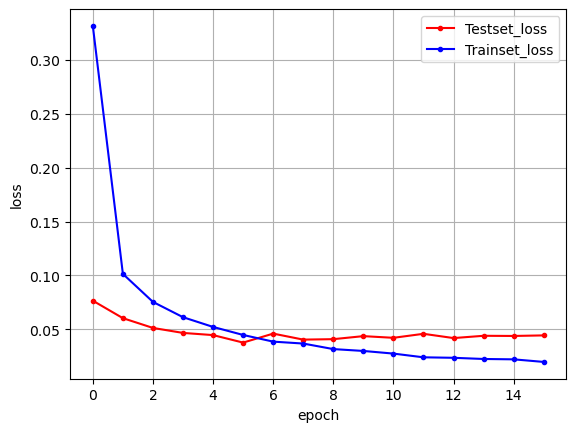

In [8]:
# 검증셋과 학습셋의 오차를 저장합니다. 
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

# 그래프로 표현해 봅니다.
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

# 그래프에 그리드를 주고 레이블을 표시해 보겠습니다.
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()